In [16]:
import json
import xmltodict
import datetime
import requests
import time
import textstat
import matplotlib.pyplot as plt 
import mwparserfromhell

In [7]:
def getEachArticle() :
    
    with open("MovieDetails.json",'r') as f :
        movieDetails = json.loads(f.read())
    
    movieNames = [x for x in movieDetails.keys()]
    
    with open("releaseDates.json",'r') as f :
        dates = json.loads(f.read())
    
    for movie in movieNames :
        name, url = movie.split('||')
        date = dates[name] if name in dates else "--"
        print(name, date)
        if date != "--" :
            AnalyzeValidEdits(name, date) #vaild means before and after 60 days
        break

In [42]:
def AnalyzeValidEdits(name, date):
    article = "./wiki/" + name.replace(' ','_') + ".xml"
    di = {}

    with open(article, 'r') as f :
        di = xmltodict.parse(f.read())
    
    revisions = [x for x in di['mediawiki']['page']['revision']] 
    revs = [] #Batch of 50s for ORES Analysis
    smog_index = []
    
    for i in range(len(revisions)) :
        diff = dateDifference(date ,revisions[i]['timestamp'].split('T')[0])
        if diff > 30 :
            continue
#         print(revisions[i]['timestamp'].split('T')[0], revisions[i]['id'], diff, len(revs))
        metrics = getReadabilityMetrics(revisions[i]['text']['#text'])
        counts = getCounts(revisions[i]['text']['#text'])
        smog_index.append(metrics['smog_index'])
        revs.append(revisions[i]['id'])
        
        if len(revs) >= 50 :
            revids = str(revs).replace(', ','|')[1:-1].replace("'","")
            revs = []
#             getORES(revids)
        if diff <= -30 :
#             getORES(revids)
            break

    plt.plot(smog_index) 
    plt.show()

In [43]:
def dateDifference(APIDate, RevisionDate) :
    converter = {"Jan":'1', "Feb":'2', "Mar":'3', "Apr":'4', 
            "May":'5', "Jun":'6', "Jul":'7', "Aug":'8',
            "Sep":'9', "Oct":'10', "Nov":'11', "Dec":'12'}
    date = APIDate.split()
    date[1] = date[1].replace(date[1], converter[date[1]])
    date = list(map(int, date[::-1]))
    x = datetime.datetime(date[0], date[1], date[2])
    date = RevisionDate
    date = list(map(int, date.split('-')))
    y = datetime.datetime(date[0], date[1], date[2])
    return (x-y).days

In [44]:
def getORES(revid):
    url = "https://ores.wikimedia.org/v3/scores/enwiki/?revids=" + str(revid)
    print(url)
    page = requests.get(url)
    di = json.loads(page.text)

In [45]:
def getReadabilityMetrics(test_data) :
    metric = {"flesch_reading_ease" : textstat.flesch_reading_ease(test_data),
                "smog_index" : textstat.smog_index(test_data),
                "flesch_kincaid_grade" : textstat.flesch_kincaid_grade(test_data),
                "coleman_liau_index" : textstat.coleman_liau_index(test_data),
                "automated_readability_index" : textstat.automated_readability_index(test_data),
                "dale_chall_readability_score" : textstat.dale_chall_readability_score(test_data),
                "difficult_words" : textstat.difficult_words(test_data),
                "linsear_write_formula" : textstat.linsear_write_formula(test_data),
                "gunning_fog" : textstat.gunning_fog(test_data),
                "text_standard" : textstat.text_standard(test_data)}
    return metric

In [46]:
def getCounts(text) :
    code = mwparserfromhell.parse(text)
    di = { "wikilinks" : len(code.filter_wikilinks()),
          "references" : text.count("<ref>"),
          "words" : text.count(" ")}
    return di

127 Hours 28 Jan 2011


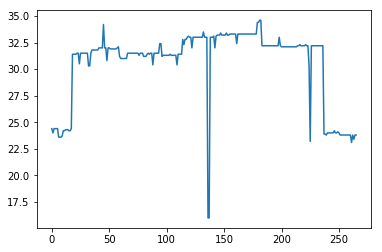

In [47]:
getEachArticle()